# prepare images

In [1]:
#import packages
from PIL import Image #Bildbearbeitungspacket (PIL = Pillow)
import numpy as np
import os # provides functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import Model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_traindata(path):
    images = []
    labels = []
    for image in sorted(os.listdir(str(path))):
        im = Image.open(str(path)+str(image))
        im = im.resize((200,200)) #resize to get all images to the same dimension
        images.append(np.array(im))
        if image[4] == 'M':
            labels.append(True)
        else:
            labels.append(False)
                
    return images, labels


In [3]:
#read in trainings and test images

train_images, train_labels = read_traindata('fold1/train/400X/')

test_images, test_labels = read_traindata('fold1/test/400X/')


In [4]:
#convert train_images, train_labels, test_images and test_labels to a numpy array
train_images = np.array(train_images) 
train_labels = np.array(train_labels) 
test_images = np.array(test_images)

#reshape train_labels and test_lab
train_labels = np.reshape(train_labels,(-1,1)) #-1 for unknown dimension

In [5]:
#conver train_labels to one-hot encoding
#hierbei wird aus [False] [1. 0.] und aus [True] [0. 1.]

enc = OneHotEncoder() #a new binary variable is added for each unique integer value
train_lab = enc.fit_transform(train_labels).toarray()


In [6]:
# normalize images by dividing them with the maximum number of pixel
# jetzt liegen die Werte zwischen 0 und 1

train_im = train_images / 255.0
test_im = test_images / 255.0

In [7]:
#build model
buffer_size = len(train_im) 
print(buffer_size)
train_ds = tf.data.Dataset.from_tensor_slices((train_im, train_lab)).shuffle(buffer_size).batch(32) #rain_ds has two tensors that are randomly sampled and batched. These tensors represent the training images and labels.


1165


# CNN Model

In [8]:
#define class CNN_Model by using Model and modifying it
# CNN_Model can identify patterns and is therefore usefull for Image analysis
# we use a convolutional/faltendes Neural Network (CNN) with dense layers for class prediction
# A convolutional layer has a number of filters that do convolutional operations. 


class CNN_Model(Model):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = Conv2D(32, 3, padding='same', activation='relu') #2D convolution layer (e.g. spatial convolution over images). --> Filter der über das Bild bewegt wird
        self.pool1 = MaxPool2D((2,2)) #Max pooling operation for 2D spatial data. --> nimmt größten Wert im Fenster 2x2 --> viertelt Anzahl an Werten
        self.conv2 = Conv2D(64, 3, padding='same', activation='relu')
        self.pool2 = MaxPool2D((2,2))
        self.flatten = Flatten() #Flattens the input. Does not affect the batch size. --> "bild wird langgezogen --> 1 dimensional"
        self.d1 = Dense(512, activation='relu') #normal NN layer, with relu as an activation function
        self.dropout1 = Dropout(0.4) # Applies Dropout to the input.
        self.d2 = Dense(128, activation='relu') 
        self.dropout2 = Dropout(0.4)
        self.d3 = Dense(43, activation='relu')
        self.d4 = Dense(2, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.dropout1(x)
        x = self.d2(x)
        x = self.dropout2(x)
        x = self.d3(x)
        x = self.d4(x)
        return x
    
model_CNN = CNN_Model()

In [9]:
#create an object for our model
#we use  Adam as our optimizer
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

#define our loss functions
#We use categorical cross-entropy as our loss function 
train_loss = tf.keras.metrics.Mean(name='train_loss') # mean value of all losses for each epoch
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy') #the accuracy measure of our model for each epoch

In [10]:
@tf.function #this decorator converts the function into a graph.
def train_step(images, labels):
    'function to train our model and computes the loss and gradients'
    with tf.GradientTape() as tape:
        'tf.GradientTape() is a high-level API that is used to compute differentiations'
        predictions = model_CNN(images)
        loss = loss_object(labels, predictions)
        
        gradients = tape.gradient(loss, model_CNN.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_CNN.trainable_variables))
        
        train_loss(loss)
        train_accuracy(labels, predictions)

In [11]:
#build and train our model
EPOCHS = 10
train_l = []
train_a = []

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)
        
    model_CNN.save_weights('./content', save_format='tf')
    train_l.append(float(train_loss.result()))
    train_a.append(float(train_accuracy.result()))
    print('Epoch:',str(epoch+1),' Loss:',str(train_loss.result()),' Accuracy:', str(train_accuracy.result()*100))
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch: 1  Loss: tf.Tensor(1.0095757, shape=(), dtype=float32)  Accuracy: tf.Tensor(68.583694, shape=(), dtype=float32)
Epoch: 2  Loss: tf.Tensor(0.49780923, shape=(), dtype=float32)  Accuracy: tf.Tensor(77.25322, shape=(), dtype=float32)
Epoch: 3  Loss: tf.Tensor(0.44850808, shape=(), dtype=float32)  Accuracy: tf.Tensor(82.23176, shape=(), dtype=float32)
Epoch: 4  Loss: tf.Tensor(0.41435254, shape=(), dtype=float32)  Accuracy: tf.Tensor(85.150215, shape=(), dtype=float32)
Epoch: 5  Loss: tf.Tensor(0.34898326, shape=(), dtype=float32)  Accuracy: tf.Tensor(85.836914, shape=(), dtype=float32)
Epoch: 6  Loss: tf.Tensor(0.3113431, shape=(), dtype=float32)  Accuracy: tf.Tensor(88.32618, shape=(), dtype=float32)
Epoch: 7  Loss: tf.Tensor(0.22961846, shape=(), dtype=float32)  Accuracy: tf.Tensor(92.017166, shape=(), dtype=float32)
Epoch: 8  Loss: tf.Tensor(0.16888396, shape=(), dtype=float32)  Accuracy: tf.Tensor(93.73391, shape=(), dtype=float32)
Epoch: 9  Loss: tf.Tensor(0.09915649, shape=()

range(0, 10) [1.0095757246017456, 0.4978092312812805, 0.448508083820343, 0.41435253620147705, 0.3489832580089569, 0.31134310364723206, 0.22961845993995667, 0.16888396441936493, 0.09915649145841599, 0.09140865504741669]


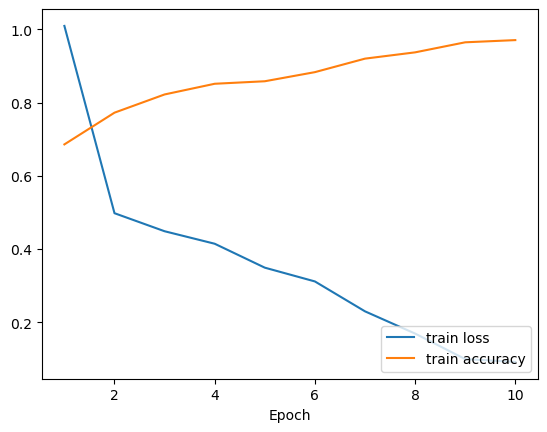

In [12]:
print(range(EPOCHS), train_l)
plt.plot(range(1,EPOCHS+1), train_l, label='train loss')
plt.plot(range(1,EPOCHS+1), train_a, label='train accuracy')
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [13]:
predictions_CNN = np.argmax(model_CNN(test_im),axis=1)

In [14]:
correct = predictions_CNN == test_labels
print(sum(correct)/len(correct))

0.816793893129771


# fully connected NN Model


In [15]:
#fully connected --> erst flatten, dann dense
# we use a fully connected neural network
#https://medium.com/swlh/fully-connected-vs-convolutional-neural-networks-813ca7bc6ee5
#fully connected:
# connect every neuron in one layer to every neuron in the other layer.

class fully_c_Model(Model):
    def __init__(self):
        super(fully_c_Model, self).__init__()
        self.flatten = Flatten() #input layer
        self.d0 = Dense(2330, activation='relu') #2330 = number of weights
        self.d1 = Dense(1165, activation='relu')
        self.d2 = Dense(582, activation='relu')
        self.d3 = Dense(291, activation='relu')
        self.d4 = Dense(146, activation='relu')
        self.d5 = Dense(2, activation='softmax') #output layer
        
    def call(self, x):
        x = self.flatten(x) 
        x = self.d0(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        x = self.d5(x)
        return x
    
model_fully_c = fully_c_Model()

In [16]:
optimizer = tf.keras.optimizers.Adam()

In [17]:
@tf.function #this decorator converts the function into a graph.
def train_step(images, labels):
    'function to train our model and computes the loss and gradients'
    with tf.GradientTape() as tape:
        'tf.GradientTape() is a high-level API that is used to compute differentiations'
        predictions = model_fully_c(images)
        loss = loss_object(labels, predictions)
        
        gradients = tape.gradient(loss, model_fully_c.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_fully_c.trainable_variables))
        
        train_loss(loss)
        train_accuracy(labels, predictions)

In [18]:
#build and train our model
EPOCHS = 10
train_l = []
train_a = []

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        
        train_step(images, labels)
        
    model_fully_c.save_weights('./content', save_format='tf')
    train_l.append(float(train_loss.result()))
    train_a.append(float(train_accuracy.result()))
    print('Epoch:',str(epoch+1),' Loss:',str(train_loss.result()),' Accuracy:', str(train_accuracy.result()*100))
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch: 1  Loss: tf.Tensor(26.468607, shape=(), dtype=float32)  Accuracy: tf.Tensor(58.197426, shape=(), dtype=float32)
Epoch: 2  Loss: tf.Tensor(1.1229208, shape=(), dtype=float32)  Accuracy: tf.Tensor(62.74678, shape=(), dtype=float32)
Epoch: 3  Loss: tf.Tensor(0.62269735, shape=(), dtype=float32)  Accuracy: tf.Tensor(70.04292, shape=(), dtype=float32)
Epoch: 4  Loss: tf.Tensor(0.5669947, shape=(), dtype=float32)  Accuracy: tf.Tensor(72.27468, shape=(), dtype=float32)
Epoch: 5  Loss: tf.Tensor(0.49317995, shape=(), dtype=float32)  Accuracy: tf.Tensor(79.3133, shape=(), dtype=float32)
Epoch: 6  Loss: tf.Tensor(0.47668734, shape=(), dtype=float32)  Accuracy: tf.Tensor(81.54507, shape=(), dtype=float32)
Epoch: 7  Loss: tf.Tensor(0.46781498, shape=(), dtype=float32)  Accuracy: tf.Tensor(81.20171, shape=(), dtype=float32)
Epoch: 8  Loss: tf.Tensor(0.45310545, shape=(), dtype=float32)  Accuracy: tf.Tensor(81.97425, shape=(), dtype=float32)
Epoch: 9  Loss: tf.Tensor(0.44851276, shape=(), dty

range(0, 10) [26.46860694885254, 1.1229207515716553, 0.6226973533630371, 0.5669947266578674, 0.49317994713783264, 0.47668734192848206, 0.46781498193740845, 0.45310544967651367, 0.4485127627849579, 0.4489307999610901]


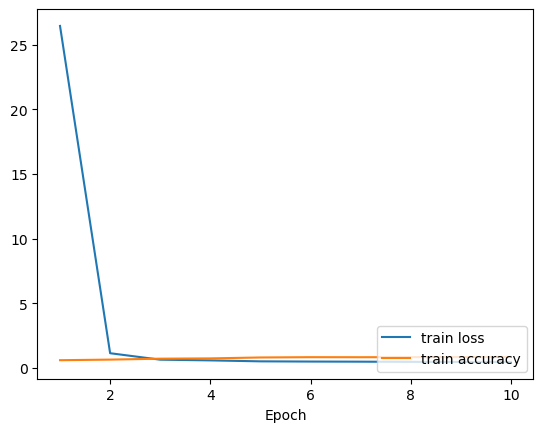

In [19]:
print(range(EPOCHS), train_l)
plt.plot(range(1,EPOCHS+1), train_l, label='train loss')
plt.plot(range(1,EPOCHS+1), train_a, label='train accuracy')
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [20]:
predictions_fully_c = np.argmax(model_fully_c(test_im),axis=1)

In [21]:
correct = predictions_fully_c == test_labels
print(sum(correct)/len(correct))

0.8061068702290076


# shallow NN model 3

In [22]:
from tensorflow.keras.layers import Embedding, LSTM
lstm = tf.keras.layers.LSTM(4)

In [23]:
class shallow_Model(Model):
    def __init__(self):
        super(shallow_Model, self).__init__()
        self.flatten = Flatten()
        self.d1 = Dense(2000, activation='relu')
        self.d2 = Dense(2, activation='softmax')
       
        
    def call(self, x): 
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x
    
model_shallow = shallow_Model()

In [24]:
optimizer = tf.keras.optimizers.Adam()

In [25]:
@tf.function #this decorator converts the function into a graph.
def train_step(images, labels):
    'function to train our model and computes the loss and gradients'
    with tf.GradientTape() as tape:
        'tf.GradientTape() is a high-level API that is used to compute differentiations'
        predictions = model_shallow(images)
        loss = loss_object(labels, predictions)
        
        gradients = tape.gradient(loss, model_shallow.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model_shallow.trainable_variables))
        
        train_loss(loss)
        train_accuracy(labels, predictions)

In [26]:
#build and train our model
EPOCHS = 10
train_l = []
train_a = []

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)
        
    model_shallow.save_weights('./content', save_format='tf')
    train_l.append(float(train_loss.result()))
    train_a.append(float(train_accuracy.result()))
    print('Epoch:',str(epoch+1),' Loss:',str(train_loss.result()),' Accuracy:', str(train_accuracy.result()*100))
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch: 1  Loss: tf.Tensor(104.43816, shape=(), dtype=float32)  Accuracy: tf.Tensor(55.53648, shape=(), dtype=float32)
Epoch: 2  Loss: tf.Tensor(2.7486284, shape=(), dtype=float32)  Accuracy: tf.Tensor(66.95279, shape=(), dtype=float32)
Epoch: 3  Loss: tf.Tensor(1.3238803, shape=(), dtype=float32)  Accuracy: tf.Tensor(72.703865, shape=(), dtype=float32)
Epoch: 4  Loss: tf.Tensor(3.655091, shape=(), dtype=float32)  Accuracy: tf.Tensor(62.83262, shape=(), dtype=float32)
Epoch: 5  Loss: tf.Tensor(1.0838524, shape=(), dtype=float32)  Accuracy: tf.Tensor(76.56652, shape=(), dtype=float32)
Epoch: 6  Loss: tf.Tensor(1.0017191, shape=(), dtype=float32)  Accuracy: tf.Tensor(72.96137, shape=(), dtype=float32)
Epoch: 7  Loss: tf.Tensor(1.4131411, shape=(), dtype=float32)  Accuracy: tf.Tensor(63.776825, shape=(), dtype=float32)
Epoch: 8  Loss: tf.Tensor(2.347049, shape=(), dtype=float32)  Accuracy: tf.Tensor(68.24034, shape=(), dtype=float32)
Epoch: 9  Loss: tf.Tensor(0.55727607, shape=(), dtype=fl

range(0, 10) [104.43816375732422, 2.7486283779144287, 1.3238803148269653, 3.6550910472869873, 1.0838524103164673, 1.0017191171646118, 1.413141131401062, 2.3470489978790283, 0.5572760701179504, 2.0198092460632324]


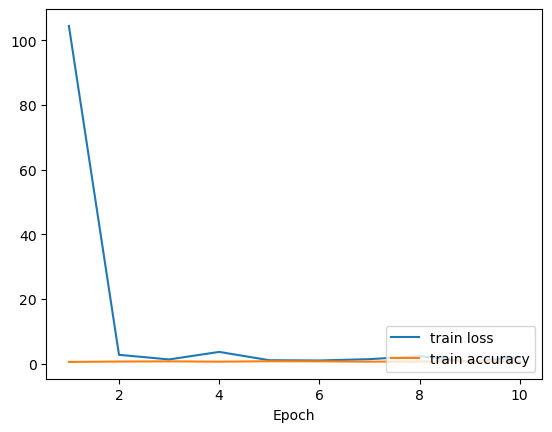

In [27]:
print(range(EPOCHS), train_l)
plt.plot(range(1,EPOCHS+1), train_l, label='train loss')
plt.plot(range(1,EPOCHS+1), train_a, label='train accuracy')
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


In [28]:
predictions_shallow = np.argmax(model_shallow(test_im),axis=1)

In [29]:
correct = predictions_shallow == test_labels
print(sum(correct)/len(correct))

0.5038167938931297


# Evaluation

In [30]:
from sklearn.metrics import confusion_matrix
# Define function to calculate multi-class sensitivity, specificity, and confusion matrix
# Based on the link: https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872
def matrix(y_test, y_pred):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round((TP/(TP+FN)).mean(),2)
    # Specificity or true negative rate
    TNR = round((TN/(TN+FP)).mean(),2)
    
    return TPR, TNR, cnf_matrix

<AxesSubplot:>

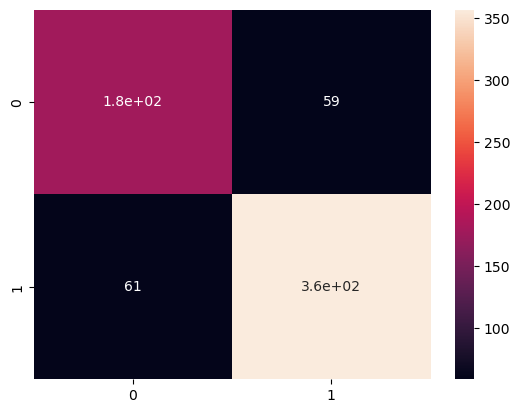

In [31]:
# Confusion matrix for CNN
sns.heatmap(matrix(test_labels, predictions_CNN)[2], annot=True)

<AxesSubplot:>

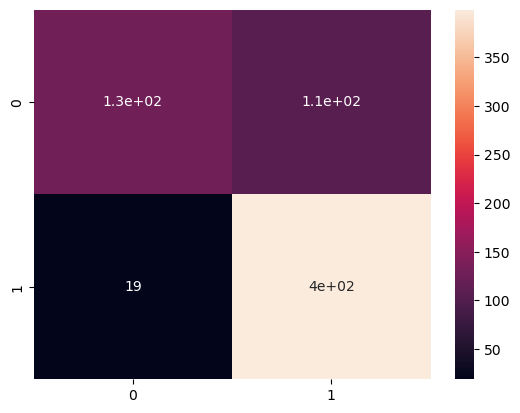

In [32]:
# Confusion matrix for fully connected NN
sns.heatmap(matrix(test_labels, predictions_fully_c)[2], annot=True)

<AxesSubplot:>

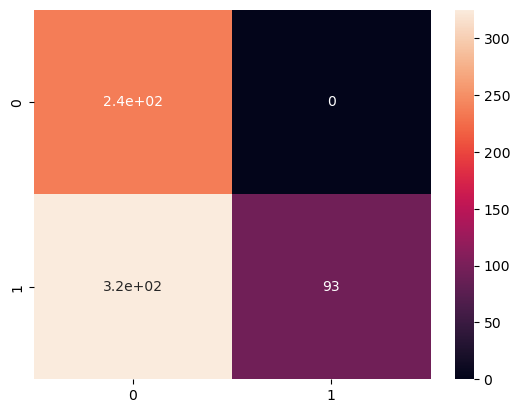

In [33]:
# Confusion matrix for shallow NN
sns.heatmap(matrix(test_labels, predictions_shallow)[2], annot=True)

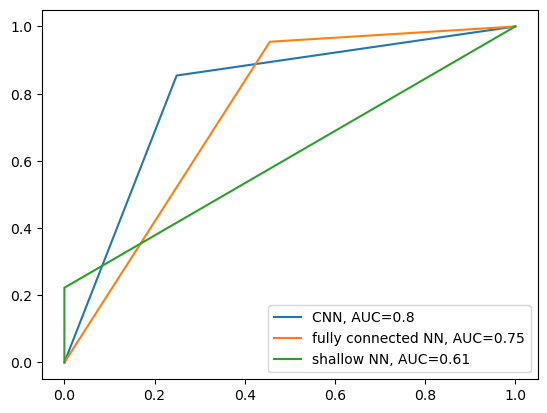

In [34]:
# ROC curves
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
classifiers = [predictions_CNN, predictions_fully_c, predictions_shallow]
labels = ["CNN", "fully connected NN", "shallow NN"]

#set up plotting area
plt.figure(0).clf()

# Plot ROC curve for each classifier
for i,j in zip(classifiers, labels):
    fpr, tpr, _ = roc_curve(test_labels, i)
    auc = round(roc_auc_score(test_labels, i), 2)
    plt.plot(fpr,tpr,label=j+", AUC="+str(auc))

#add legend
plt.legend()